In [1]:
#This file contains noun phrase and n-gram filters on Inspec dataset

import glob, os
from datetime import datetime
from natsort import natsorted
import utils, preprocessing, generate_candidate
import feature_extraction, generate_keyphrase

2018-08-27 16:59:18,038: DEBUG: CACHEDIR=C:\Users\user\.matplotlib
2018-08-27 16:59:18,105: DEBUG: Using fontManager instance from C:\Users\user\.matplotlib\fontList.json
2018-08-27 16:59:22,577: DEBUG: backend module://ipykernel.pylab.backend_inline version unknown
2018-08-27 16:59:24,310: DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


In [ ]:
#only run one time, if pickles have been generated, please skip into next step

#load and create training data
train_directory = natsorted(glob.glob('./data/inspec/train/*.xml'))
train_raw = preprocessing.load_xml_non_title(train_directory)
pickle_train_raw = utils.create_pickle(train_raw,'./pickle/inspec/train raw')
train_data = preprocessing.create_xml_corpus(train_raw)
pickle_train_data = utils.create_pickle(train_data,'./pickle/inspec/train data')
train_tf_corpus = feature_extraction.calculate_tf(train_data, vocab = None, type = 'ngram')
pickle_train_tf_corpus = utils.create_pickle(train_tf_corpus,'./pickle/inspec/train tf corpus')

#load and create testing data
test_directory = natsorted(glob.glob('./data/inspec/test/*.xml'))
test_raw = preprocessing.load_xml_non_title(test_directory)
pickle_test_raw = utils.create_pickle(test_raw,'./pickle/inspec/test raw')
test_data = preprocessing.create_xml_corpus(test_raw)
pickle_test_data = utils.create_pickle(test_data,'./pickle/inspec/test data')
test_tf_corpus = feature_extraction.calculate_tf(test_data, vocab = None, type = 'ngram')
pickle_test_tf_corpus = utils.create_pickle(test_tf_corpus,'./pickle/inspec/test tf corpus')

#create training label
uncontr_train_label_directory = open('./data/Inspec/references/train.uncontr.stem.json')
uncontr_train_label = preprocessing.extract_json_label(uncontr_train_label_directory, 
                                                     raw_data = train_raw, file_type='default')
uncontr_train_label_pickle = utils.create_pickle(uncontr_train_label, 
                                                 './pickle/Inspec/uncontr train label')

#create testing label
uncontr_test_label_directory = open('./data/Inspec/references/test.uncontr.stem.json')
uncontr_test_label = preprocessing.extract_json_label(uncontr_test_label_directory, 
                                                    raw_data = test_raw, file_type='default')
uncontr_test_label_pickle = utils.create_pickle(uncontr_test_label, 
                                                './pickle/Inspec/uncontr test label')


#create candidates based on n-gram and store into pickle of training data
print("Generating n-gram candidates..")
ngram_candidates = generate_candidate.calculate_tfidf(train_data, vocab=None, type='ngram') 
pickle_ngram_candidates = utils.create_pickle(ngram_candidates, './pickle/inspec/ngram candidates')

#create candidates based on n-gram and store into pickle of testing data
test_ngram_candidates = generate_candidate.calculate_tfidf(test_data, vocab=None, type='ngram') 
pickle_test_ngram_candidates = utils.create_pickle(test_ngram_candidates, 
                                                   './pickle/inspec/test ngram candidates')


#create candidates based on noun phrase and store into pickle of training data
print("Generating noun phrase candidates..")
nounphrase_vocabulary = generate_candidate.create_phrase_vocabulary(train_data)
train_tf_nounphrase_corpus = feature_extraction.calculate_tf(train_data, 
                            vocab = nounphrase_vocabulary, type = 'np')
pickle_train_tf_nounphrase_corpus = utils.create_pickle(train_tf_nounphrase_corpus,
                            './pickle/inspec/train tf nounphrase corpus')
nounphrase_candidates = generate_candidate.calculate_tfidf(train_data, 
                            nounphrase_vocabulary, type='np')
pickle_nounphrase_candidates = utils.create_pickle(nounphrase_candidates, 
                            './pickle/inspec/nounphrase candidates')

#create candidates based on noun phrase and store into pickle of testing data
test_nounphrase_vocabulary = generate_candidate.create_phrase_vocabulary(test_data)
test_tf_nounphrase_corpus = feature_extraction.calculate_tf(test_data, 
                            vocab = test_nounphrase_vocabulary, type = 'np')
pickle_test_tf_nounphrase_corpus = utils.create_pickle(test_tf_nounphrase_corpus,
                            './pickle/inspec/test tf nounphrase corpus')
test_nounphrase_candidates = generate_candidate.calculate_tfidf(test_data, 
                            test_nounphrase_vocabulary, type='np')
pickle_test_nounphrase_candidates = utils.create_pickle(test_nounphrase_candidates, 
                            './pickle/inspec/test nounphrase candidates')

#create a dictionary supervised keyphraseness on ngram filter
supervised_key = feature_extraction.create_supervised_list(uncontr_train_label, train_tf_corpus)
supervised_corpus = utils.create_pickle(supervised_key, './pickle/inspec/supervised keyphraseness')

#create a dictionary supervised keyphraseness on noun phrase filter
np_supervised_key = feature_extraction.create_supervised_list(uncontr_train_label, train_tf_nounphrase_corpus)
np_supervised_corpus = utils.create_pickle(np_supervised_key, './pickle/inspec/np supervised keyphraseness')


In [2]:
#evaluate the pipeline

#evaluation on Inspec with uncontrolled label (10 keywords)
number_keyphrase = 10

#open all relevant pickles
print("Opening all pickles")
train_raw = utils.open_pickle('./pickle/inspec/train raw')
train_data = utils.open_pickle('./pickle/inspec/train data')

uncontr_train_label = utils.open_pickle('./pickle/inspec/train uncontr label')
train_tf_corpus = utils.open_pickle('./pickle/inspec/train tf corpus')

test_raw = utils.open_pickle('./pickle/inspec/test raw')
test_data = utils.open_pickle('./pickle/inspec/test data')

uncontr_test_label = utils.open_pickle('./pickle/inspec/test uncontr label')
test_tf_corpus = utils.open_pickle('./pickle/inspec/test tf corpus')

train_topics = utils.open_pickle('./pickle/inspec/train topics')
test_topics = utils.open_pickle('./pickle/inspec/test topics')

ngram_candidates = utils.open_pickle('./pickle/inspec/ngram candidates')
test_ngram_candidates = utils.open_pickle('./pickle/inspec/test ngram candidates')

train_tf_nounphrase_corpus = utils.open_pickle('./pickle/inspec/train tf nounphrase corpus')
test_tf_nounphrase_corpus = utils.open_pickle('./pickle/inspec/test tf nounphrase corpus')

nounphrase_candidates = utils.open_pickle('./pickle/inspec/nounphrase candidates')
test_nounphrase_candidates = utils.open_pickle('./pickle/inspec/test nounphrase candidates')

supervised_corpus = utils.open_pickle('./pickle/inspec/supervised keyphraseness')
np_supervised_key = utils.open_pickle('./pickle/inspec/np supervised keyphraseness')


#create examples on training and testing data
#uncomment if the pickles are not available
'''
print("Creating examples of n-gram on training and testing data..")
ngram_train = feature_extraction.create_features(train_data, 
                ngram_candidates, uncontr_train_label, 
                supervised_corpus, train_tf_corpus, 
                train_topics, name='./csv/inspec/mod_uncontr_train_ngram', 
                n_keyphrase = number_keyphrase)
               
ngram_test = feature_extraction.create_features(test_data, 
                test_ngram_candidates, uncontr_test_label, 
                supervised_corpus, test_tf_corpus,
                test_topics, name='./csv/inspec/mod_uncontr_test_ngram',
                n_keyphrase = number_keyphrase)


print("Creating examples of noun phrase on training and testing data..")
nounphrase_train = feature_extraction.create_features(train_data,
                nounphrase_candidates, uncontr_train_label, np_supervised_key, train_tf_nounphrase_corpus, 
                train_topics, name='./csv/inspec/uncontr_train_nounphrase', 
                n_keyphrase = number_keyphrase) 

nounphrase_test = feature_extraction.create_features(test_data, 
                test_nounphrase_candidates, uncontr_test_label, np_supervised_key, test_tf_nounphrase_corpus, 
                test_topics, name='./csv/inspec/uncontr_test_nounphrase', 
                n_keyphrase = number_keyphrase)
'''

#evaluation
print("Evaluation on n-gram filter..")
ngram_prediction = generate_keyphrase.predict_data(test_ngram_candidates, 
                uncontr_test_label, train_data='./csv/inspec/uncontr_train_ngram', 
                test_data='./csv/inspec/uncontr_test_ngram', 
                n_keyphrase = number_keyphrase)
print('Precision, recall, f-measure on 10 keywords - ngram :', ngram_prediction)

#generate the result of prediction into excel
ngram_prediction_keyphrase = generate_keyphrase.get_predicted_keyphrases(test_ngram_candidates,
                    train_data='./csv/inspec/uncontr_train_ngram', 
                    test_data='./csv/inspec/uncontr_test_ngram', 
                    csv_name='./csv/inspec/uncontr predicted ngram keyphrases keywords', 
                    n_keyphrase = number_keyphrase)


#evaluation
print("Evaluation on noun phrase filter..")
np_prediction = generate_keyphrase.predict_data(test_nounphrase_candidates, uncontr_test_label, 
                train_data='./csv/inspec/uncontr_train_nounphrase', 
                test_data='./csv/inspec/uncontr_test_nounphrase', 
                n_keyphrase = number_keyphrase)
print('Precision, recall, f-measure on top 10 keyphrase - nounphrase:', np_prediction)

#generate the result of prediction into excel
np_prediction_keyphrase = generate_keyphrase.get_predicted_keyphrases(test_nounphrase_candidates,
                    train_data='./csv/inspec/uncontr_train_nounphrase', 
                    test_data='./csv/inspec/uncontr_test_nounphrase', 
                    csv_name='./csv/inspec/uncontr predicted np keyphrases keywords', 
                    n_keyphrase = number_keyphrase)


Opening all pickles
Evaluation on n-gram filter..
Fmeasure on full features:
Precision, recall, f-measure on 10 keywords - ngram : [('LR', (17.46, 17.77, 17.61))]
Evaluation on noun phrase filter..
Fmeasure on full features:
Precision, recall, f-measure on top 10 keyphrase - nounphrase: [('LR', (24.36, 24.79, 24.57))]


2018-08-27 16:59:44,614: DEBUG: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\user\\AppData\\Roaming\\Python\\Python35\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000
2018-08-27 16:59:46,224: DEBUG: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('C:\\Users\\user\\AppData\\Roaming\\Python\\Python35\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


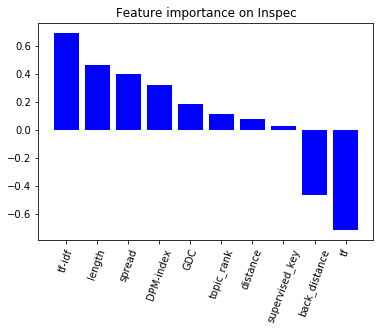

Feature importance on noun phrase filter: None


In [3]:
#calculate feature importance
weight = generate_keyphrase.feature_importance(train_data = './csv/inspec/uncontr_train_nounphrase_data.csv',
                                            test_data = './csv/inspec/uncontr_test_nounphrase_data.csv',
                                            name = 'Inspec')
print('Feature importance on noun phrase filter:', weight)